# Final Project
- Boesso Simone, matr. 1800408;
- Cacciatore Davide, matr. 2015641;
- Corsetti Giulio, matr. 1864712;
- Possenti Francesca, matr. ;
- Russo Letizia, matr. 1869768.

### Material
We import the libraries needed and we upload the dataset.

In [26]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics

In [27]:
# We load the data
dataset = pd.read_csv("spam.csv")
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [28]:
# We drop the redundent looking columns
unuseful = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"]
dataset = dataset.drop(dataset[unuseful], axis=1)

# We rename the columns in order to make them more understandable
dataset.rename(columns = {"v1":"Target", "v2":"Text"}, inplace = True)
dataset.head()

,Target,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Text(0, 0.5, 'Number of Data points')

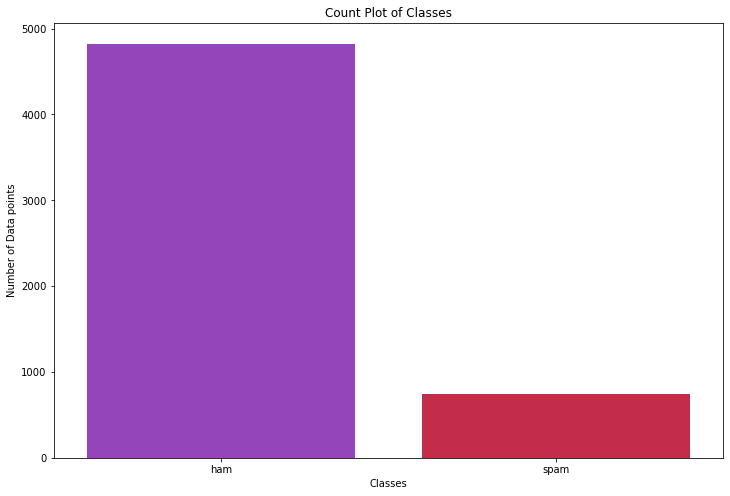

In [29]:
# We choose two colors
cols = ["darkorchid", "crimson"] 

# We evaluate the target and find out if our data is balanced or not
plt.figure(figsize=(12,8))
fg = sns.countplot(x = dataset["Target"], palette = cols)
fg.set_title("Count Plot of Classes", color="black")
fg.set_xlabel("Classes", color="black")
fg.set_ylabel("Number of Data points", color="black")

Clearly our dataset is not balanced, in fact we have almost 5000 ham and less than 1000 spam.

It can be useful to create new features as follows:
- Characters: number of characters in the text message;
- Words: number of words in the text message;
- Sentences: number of sentences in the text message.

In [30]:
# We tokenise the words and sentences and use the length of the same. 
# Adding a column of numbers of charachters, words and sentences in each message.
dataset["Characters"] = dataset["Text"].apply(len)
dataset["Words"] = dataset.apply(lambda row: nltk.word_tokenize(row["Text"]), axis=1).apply(len)
dataset["Sentences"] = dataset.apply(lambda row: nltk.sent_tokenize(row["Text"]), axis=1).apply(len)

round(dataset.describe().T,2)

,count,mean,std,min,25%,50%,75%,max
Characters,5572.0,80.06,59.62,2.0,36.0,61.0,121.0,910.0
Words,5572.0,18.70,13.74,1.0,9.0,15.0,27.0,220.0
Sentences,5572.0,1.99,1.50,1.0,1.0,2.0,2.0,38.0


As we can see, we have the same number of characters, words and sentences. We can see that the mean number of characters in the messages is $80.06$, the mean number of words is $18.70$ and the mean number of sentences is $1.99$. The characters have a standard deviation higher than the others.

<Figure size 864x576 with 0 Axes>

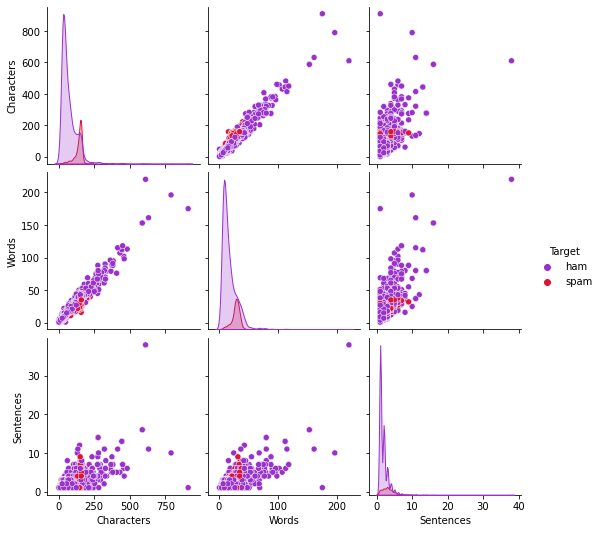

In [31]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=dataset, hue="Target", palette=cols)
plt.show(fg)

In [32]:
# We can't forget to drop the outliers. 
dataset = dataset[(dataset["Characters"]<350)]
dataset.shape

(5548, 5)

<Figure size 864x576 with 0 Axes>

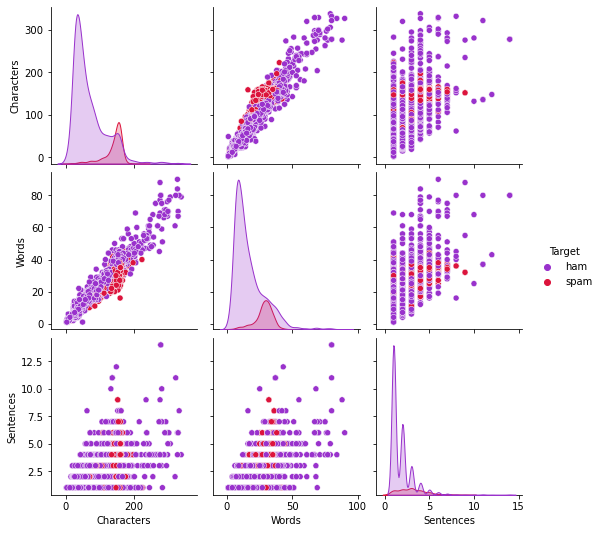

In [33]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=dataset, hue="Target", palette=cols)
plt.show(fg)

### Phase 1: Data Preprocessing
In order to further process the data, we need to make the data cleaner.

In the first step we extract only the alphabetic characters, so we remove punctuation and numbers. Then we convert all the characters into lowercase.

In [34]:
# Function to clean up the text
def Clean(Text):
    
    # We replacing all non-alphabetic characters with a space
    sms = re.sub('[^a-zA-Z]', ' ', Text) 
    
    # We convert the uppercase into lowercase
    sms = sms.lower() 
    
    # We split 
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

dataset["Clean_Text"] = dataset["Text"].apply(Clean)

# Have a look at a sample of texts after cleaning
print("\033[1m\u001b[45;1m The First 5 Texts after cleaning:\033[0m",*dataset["Clean_Text"][:5], sep = "\n")

 The First 5 Texts after cleaning:
go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


In [35]:
# In order to break complex data into smaller units, we apply the tokenization. 
# It can be done by splitting paragraphs into sentences and sentences into words.

# We split the Clean_Text into words.
dataset["Tokenize_Text"] = dataset.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)

print("\033[1m\u001b[45;1m The First 5 Texts after Tokenizing:\033[0m", *dataset["Tokenize_Text"][:5], sep = "\n")

 The First 5 Texts after Tokenizing:
['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']


In [36]:
# For the purpose of removing redundancy from the process, we remove the stopwords.
def remove_stopwords(text):
    
    # We configure for the language "english"
    stop_words = set(stopwords.words("english"))
    
    # We create a new list called filtered_text which contains all words which are not stop words.
    # To create it we iterate over the list of words and only add it if it's not in the stop_words set.
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

dataset["Nostopword_Text"] = dataset["Tokenize_Text"].apply(remove_stopwords)

print("\033[1m\u001b[45;1m The First 5 Texts after removing the stopwords:\033[0m",*dataset["Nostopword_Text"][:5], sep = "\n")

 The First 5 Texts after removing the stopwords:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']


In [37]:
# The lemmatization converts a word to its root form, ensuring that the root word belongs 
# to the English language (because we choose it), so we will obtain an output in English.

# Lemmatize string
lemmatizer = WordNetLemmatizer()

def lemmatize_word(text):
    # word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

dataset["Lemmatized_Text"] = dataset["Nostopword_Text"].apply(lemmatize_word)
print("\033[1m\u001b[45;1m The First 5 Texts after lemitization:\033[0m",*dataset["Lemmatized_Text"][:5], sep = "\n")

 The First 5 Texts after lemitization:
['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'get', 'amore', 'wat']
['ok', 'lar', 'joke', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'go', 'usf', 'live', 'around', 'though']


In [38]:
# In NLP, cleaned data needs to be converted into a numerical format where each word is represented by a matrix. 

#Creating a corpus of text feature to encode further into vectorized form
corpus = []
for i in dataset["Lemmatized_Text"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)
    
print("\033[1m\u001b[45;1m The First 5 lines in corpus :\033[0m",*corpus[:5], sep = "\n")

# We replace text data with numbers
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()

# Output
X.dtype

# Label encode the Target and use it as y
label_encoder = LabelEncoder()
dataset["Target"] = label_encoder.fit_transform(dataset["Target"])

 The First 5 lines in corpus :
go jurong point crazy available bugis n great world la e buffet cine get amore wat
ok lar joke wif u oni
free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
u dun say early hor u c already say
nah think go usf live around though


### Phase 2: Model building

Potremmo confrontare il naive bayes con altri tipi di modelli (tipo logistic regression oppure swm) ed usare diverse metriche come df1 score (fatto/nominato da Galasso).

Setting up features and target as X and y

In [39]:
# Setting values for labels and feature as y and X (we already did X in vectorizing...)
y = dataset["Target"] 
# Splitting the testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# Testing on the following classifiers
classifiers = [MultinomialNB(), 
               RandomForestClassifier(),
               KNeighborsClassifier(), 
               SVC()]
for cls in classifiers:
    cls.fit(X_train, y_train)
    
# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "NaiveBayes", 1: "RandomForest", 2: "KNeighbours",3: "SVC"}

In [41]:
# Crossvalidation 
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train,y_train,scoring="accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

NaiveBayes: 0.967552 
RandomForest: 0.975664 
KNeighbours: 0.911450 
SVC: 0.974086 


Model Evaluation

In [42]:
# creating lists of varios scores
precision =[]
recall =[]
f1_score = []
trainset_accuracy = []
testset_accuracy = []

for i in classifiers:
    pred_train = i.predict(X_train)
    pred_test = i.predict(X_test)
    prec = metrics.precision_score(y_test, pred_test)
    recal = metrics.recall_score(y_test, pred_test)
    f1_s = metrics.f1_score(y_test, pred_test)
    train_accuracy = model.score(X_train,y_train)
    test_accuracy = model.score(X_test,y_test)
  
    #Appending scores
    precision.append(prec)
    recall.append(recal)
    f1_score.append(f1_s)
    trainset_accuracy.append(train_accuracy)
    testset_accuracy.append(test_accuracy)

In [43]:
# initialise data of lists.
data = {'Precision':precision,
'Recall':recall,
'F1score':f1_score,
'Accuracy on Testset':testset_accuracy,
'Accuracy on Trainset':trainset_accuracy}
# Creates pandas DataFrame.
Results = pd.DataFrame(data, index =["NaiveBayes", "RandomForest", "KNeighbours","SVC"])

In [44]:
cmap2 = ListedColormap(["#E2CCFF","#E598D8"])
Results.style.background_gradient(cmap=cmap2)

,Precision,Recall,F1score,Accuracy on Testset,Accuracy on Trainset
NaiveBayes,1.000000,0.705882,0.827586,0.974775,0.997521
RandomForest,1.000000,0.823529,0.903226,0.974775,0.997521
KNeighbours,0.977778,0.323529,0.486188,0.974775,0.997521
SVC,0.990909,0.801471,0.886179,0.974775,0.997521


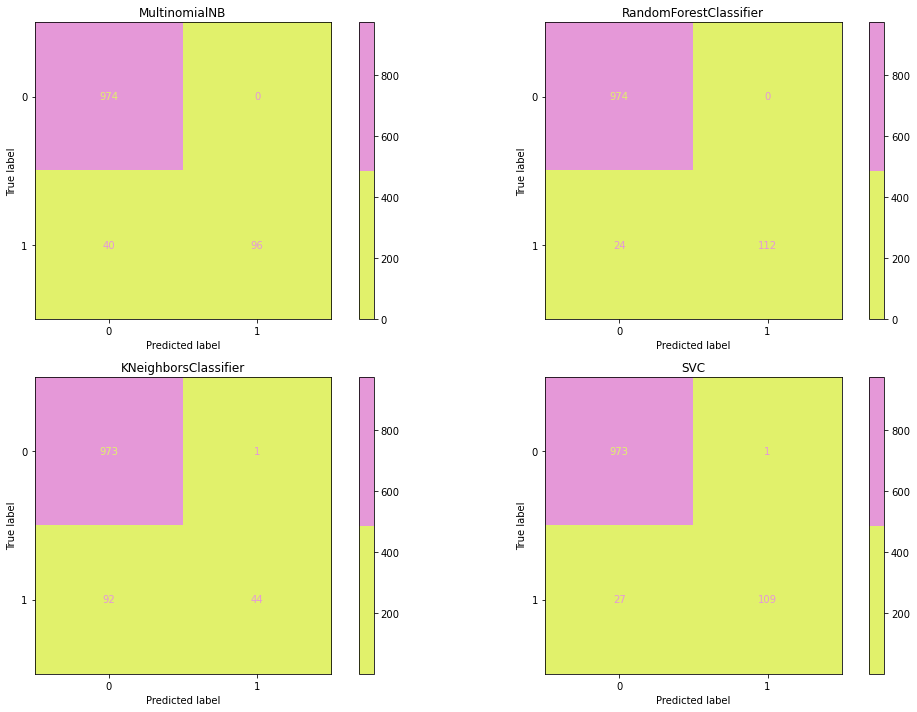

In [45]:
cmap = ListedColormap(["#E1F16B", "#E598D8"])
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for cls, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap= cmap,   
                          )
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()